# Extrator de entidades - sequence to class - BiLSTM  e Attention

In [1]:
# Script for training neural model with embedding
import os, sys
import pandas as pd
import numpy as np
from omni.nlp import TextProcessing
from gensim.models import Word2Vec
import logging
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Input, LSTM, TimeDistributed, Bidirectional
from tensorflow.python.keras.layers import Concatenate
from sklearn.metrics import accuracy_score
from tensorflow.python.keras.models import load_model
import json
import string
from itertools import compress
from tensorflow.python.keras.models import Model as ModelKeras

from mlflow import log_metric, log_param, log_artifact, set_tracking_uri, set_experiment, start_run
import mlflow.tensorflow

translator = str.maketrans('', '', string.punctuation)
keys_translator = list(translator.keys())
key_to_change = [x == '-' for x in string.punctuation]
for key in list(compress(keys_translator, key_to_change)):
    translator[key] = " "

from collections import Counter
import operator

from tqdm import tqdm

from tensorflow.python.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.25
sess = tf.Session(config=config)

from tensorflow.python.keras.utils import CustomObjectScope

/opt/anaconda3/envs/entity-extractor2/lib/python3.6/site-packages/swifter/swifter.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/opt/anaconda3/envs/entity-extractor2/lib/python3.6/site-packages/swifter/swifter.py:11: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.errors', please update to use 'numba.core.errors' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.errors import TypingError
/opt/anaconda3/envs/entity-extractor2/lib/python3.6/site-packages/swifter/swifter.py:11: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'TypingError' requested from: 'numba.errors', please update to use 'numba.core.errors' or pin to Numba version 0.48.0. This alias will not be present in Numba

## Funções auxiliares

In [2]:
#==================================================
#Functions

def text_preprocessing(txt):
    nlp = TextProcessing()
    txt = nlp.preprocess_str(txt=txt, clean_html=False, explode_digits=False)
    #txt = nlp.preprocess_str(txt=txt, clean_html=False)
    txt = txt.translate(translator)

    return txt


def convert_tokens_to_charvec_timeframes(dataframe=None, column_selected=None, embedding_model=None,
                                         char_max_length=None, max_length=None, char_to_int_dict=None):

    # Preparando o conjunto de dados de entrada com timestamps (vetores e indices)
    vectors_dim = 256

    dataX_vec = np.zeros([dataframe.shape[0], max_length, vectors_dim], dtype='float16')

    print(dataX_vec.shape)
    
    i = 0
    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        seq = 0
        txt = str(row[column_selected])
        tokens = list(txt.split(" "))
        for item in tokens:
            if seq < max_length:
                # Evaluate a word
                word_vec = get_char_embedding_from_word(word=item, model_emb=embedding_model, char_to_int_dict=char_to_int_dict,
                                                        max_length=char_max_length)
                dataX_vec[i, seq, :] = word_vec
            else:
                break
            seq = seq + 1
        i = i + 1

    return dataX_vec

def get_char_embedding_from_word(word, model_emb, char_to_int_dict, max_length):
    dim = len(char_to_int_dict)
    encoded_data = np.zeros((1, max_length, dim), dtype='int')

    seq = 0
    for char in word:
        if seq < max_length:
            encoded_data[0, seq, char_to_int_dict[char]] = 1
            seq = seq + 1
        else:
            break

    # implementacao para uma entrada de seq
    states_value_seq = model_emb.predict(encoded_data)
    embedded_samples = states_value_seq[0][0]

    return embedded_samples


def convert_tokens_to_vec_timeframes_w2v(dataframe=None, column_selected=None, embedding_model=None, embedding_model_code=None,
                                         max_length=None, verbose=None):
    nlp = TextProcessing()
    if embedding_model_code == 'gensim_word2vec' or embedding_model_code == 'gensim_fasttext':

        # Preparando o conjunto de dados de entrada com timestamps (vetores e indices)
        vectors_dim = embedding_model.wv.vector_size

        dataX_vec = np.zeros([dataframe.shape[0], max_length, vectors_dim], dtype='float16')

        # Transforming txt lists to lists of lists
        nlp = TextProcessing()
        list_tokens_input = nlp.convert_txt_of_tokens_to_list_of_tokens_from_pandas(
            dataframe=dataframe,
            column_selected=column_selected)

        # Qtde de palavras a serem processadas
        list_tokens_flat = nlp.flat_list_2D(list_tokens_input)
        qtde_tokens_input = len(list_tokens_flat)
        qtde_tokens_dist = len(set(list_tokens_flat))

        # Qtde de palavras mapeadas no espaco
        qtde_tokens_espaco = len(embedding_model.wv.vocab)

        if verbose > 1:
            logging.info('Total of distinct tokens from dataset input : ' + str(qtde_tokens_dist))

        # iniciando contador de amostras
        index_sample = 0

        # iniciando o vetor de tamanhos de sentencas
        samples_len = np.zeros(len(list_tokens_input), dtype='int16')
        tokens_not_found = np.zeros(len(list_tokens_input), dtype='int16')
        tokens_not_found_txt = []
        samples_tokens_cover = np.zeros(len(list_tokens_input), dtype='float16')

        # para cada sentenca na matriz de entrada
        for line in tqdm(list_tokens_input):
            index_token = 0
            samples_len[index_sample] = len(line)
            # para cada token da sentenca de entrada
            for token in line:
                if index_token < max_length:
                    if token in embedding_model.wv.vocab:
                        # se o token existe no wv podemos validar um timeframe valido
                        dataX_vec[index_sample, index_token, :] = embedding_model.wv[token]
                    else:
                        # o token nao existe no espaco semantico - nao avancar no timeframe
                        tokens_not_found[index_sample] = tokens_not_found[index_sample] + 1

                        # armazenando lista de tokens nao encontrados
                        tokens_not_found_txt.append(token)

                        # qdo token nao é mapeado nao se considera no vetor de entrada (retorno do contador se nao estourou o limite)
                        if tokens_not_found[index_sample] < max_length:
                            index_token = index_token - 1
                        else:
                            index_token = max_length
                            if verbose > 1:
                                logging.error(
                                    'Not found embedding tokens enough to build this sample input: ' + str(line))

                index_token += 1

            # contabilizando cobertura de tokens
            samples_tokens_cover[index_sample] = (samples_len[index_sample] - tokens_not_found[index_sample]) / \
                                                 samples_len[index_sample]

            index_sample += 1

        # todo fazer revisao dos tokens e apresentar so um consolidado

        if verbose > 1:
            logging.info('Mean size of txt input (tokens): ' + str(samples_len.mean()))
            logging.info('Min size of txt input (tokens): ' + str(samples_len.min()))
            logging.info('Max size of txt input (tokens): ' + str(samples_len.max()))

            # Calculando cobertura do espaco semantico
            logging.info('Total of processed tokens: ' + str(qtde_tokens_input))
            logging.info('Total of not embedded tokens: ' + str(tokens_not_found.sum()))
            logging.info('Tokens volume embedding covering: ' + str(
                (qtde_tokens_input - tokens_not_found.sum()) / (qtde_tokens_input)))

        # Cobertura em variedade de tokens
        perc_cobertura = ((qtde_tokens_espaco) - (len(set(tokens_not_found_txt)))) / (qtde_tokens_espaco)

        if verbose > 1:
            logging.info('Tokens variety embedding covering: ' + str(perc_cobertura))

        # Padronizando a entrada de dados com uma dimensionalidade constante
        X_pad_vec = pad_sequences(dataX_vec, maxlen=max_length, dtype='float16', padding='post', truncating='post',
                                  value=0.0)

        return X_pad_vec, samples_tokens_cover
    else:
        raise (Exception('Invalid embedding model code selection: ' + embedding_model_code))
        return False

def plot_attention_weights2(encoder_inputs, attention_weights, classe):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    attention_mat = attention_weights[0]
    
    fig, ax = plt.subplots(figsize=(32, 32))
    ax.imshow(attention_mat)

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_xticklabels(classe)
    ax.set_yticklabels([inp if inp != 0 else "<Res>" for inp in encoder_inputs.split(' ')])

        
def convert_tokens_to_charvec_timeframes_text(txt=None, embedding_model=None,
                                         char_max_length=None, max_length=None, char_to_int_dict=None):
    # Preparando o conjunto de dados de entrada com timestamps (vetores e indices)
    vectors_dim = 256
    
    dataX_vec = np.zeros([1, max_length, vectors_dim], dtype='float16')
    
    tokens = list(txt.split(" "))
    seq = 0
    for item in tokens:
        if seq < max_length:
            # Evaluate a word
            word_vec = get_char_embedding_from_word(word=item, model_emb=embedding_model, char_to_int_dict=char_to_int_dict,
                                                    max_length=char_max_length)
            dataX_vec[0, seq, :] = word_vec
        else:
                break
        seq = seq + 1
    return dataX_vec

def convert_tokens_to_w2v_timeframes_text(txt=None, column_selected=None, embedding_model=None,
                                         char_max_length=None, max_length=None, char_to_int_dict=None):
    # Preparando o conjunto de dados de entrada com timestamps (vetores e indices)
    vectors_dim = embedding_model.wv.vector_size

    dataX_vec = np.zeros([1, max_length, vectors_dim], dtype='float16')
    
    tokens = list(txt.split(" "))
    seq = 0
    for item in tokens:
        if seq < max_length:
            # Evaluate a word
            if item in embedding_model.wv.vocab:
                # se o token existe no wv podemos validar um timeframe valido
                dataX_vec[0, seq, :] = embedding_model.wv[item]
                seq = seq + 1
        
    return dataX_vec

In [3]:
#create a integer dictionary from output text class
def build_integer_class_dictionary_from_pandas(df_data, column_selected):

    classes = []

    #collecting distinct tokens
    for index, row in df_data.iterrows():
        txt = str(row[column_selected])

        if txt not in classes:
            classes.append(txt)

    classes = sorted(list(classes))

    #reporting
    num_classes = len(classes)

    print('Number of unique classes:', num_classes)

    dict_int2txt = dict(
        [(i, tk) for i, tk in enumerate(classes)])
    dict_txt2int = dict(
        [(tk, i) for i, tk in enumerate(classes)])

    return dict_int2txt, dict_txt2int

#create one-hot encode from txt and integer dictionary
def build_one_hot_encoding_from_classes_target(df_data, column_selected, dict_txt2int):

    n_samples = df_data[column_selected].shape[0]
    dim = len(dict_txt2int)
    encoded_target_data = np.zeros((n_samples, dim), dtype='int')

    # assign 1's
    sample = 0
    for index, row in df_data.iterrows():

        txt = str(row[column_selected])
        encoded_target_data[sample, dict_txt2int[txt]] = 1
        sample = sample + 1

    return encoded_target_data

In [4]:
def balanced_sample_maker(X, y, sample_size, random_seed=None):
    """ return a balanced data set by sampling all classes with sample_size 
        current version is developed on assumption that the positive
        class is the minority.

    Parameters:
    ===========
    X: {numpy.ndarrray}
    y: {numpy.ndarray}
    """
    uniq_levels = np.unique(y)
    uniq_counts = Counter(y)

    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    return balanced_copy_idx

In [38]:
def classifier_substantive_sequence_txt(input_text):
    
    input_seq1 = convert_tokens_to_charvec_timeframes_text(txt=input_text, embedding_model=wordchar2vec,
                                         char_max_length=max_char_lenght, max_length=max_length, char_to_int_dict=char_to_int_dict)
    input_seq2 = convert_tokens_to_w2v_timeframes_text(txt=input_text, embedding_model=word2vec,
                                         char_max_length=max_char_lenght, max_length=max_length, char_to_int_dict=char_to_int_dict)
    
    # Encode the input as state vectors.
    encoder_char_outputs, char_last_forward_h1, char_last_forward_c1, char_last_backward_h1, char_last_backward_c1 = encoder_char_model.predict(input_seq1)
    encoder_w2v_outputs, w2v_last_forward_h1, w2v_last_forward_c1, w2v_last_backward_h1, w2v_last_backward_c1 = encoder_w2v_model.predict(input_seq2)

    char_state_h = np.concatenate((char_last_forward_h1, char_last_backward_h1), axis=1)
    char_state_c = np.concatenate((char_last_forward_c1, char_last_backward_c1), axis=1)
    
    w2v_state_h = np.concatenate((w2v_last_forward_h1, w2v_last_backward_h1), axis=1)
    w2v_state_c = np.concatenate((w2v_last_forward_c1, w2v_last_backward_c1), axis=1)
    
    enc_state_h = np.concatenate((char_state_h, w2v_state_h), axis=1)
    #print(states_value_h.shape)
    enc_outs = np.concatenate((encoder_char_outputs, encoder_w2v_outputs), axis=2)

    
    decoder_inf_pred, attention_weights = classifier_model.predict([enc_outs, enc_state_h])
    
    key = np.argmax(decoder_inf_pred)
    
    return int_to_label_dict[str(key)], attention_weights

In [6]:
def get_encoder_attention_context_vector(input_text):
    
    input_seq1 = convert_tokens_to_charvec_timeframes_text(txt=input_text, embedding_model=wordchar2vec,
                                         char_max_length=max_char_lenght, max_length=max_length, char_to_int_dict=char_to_int_dict)
    input_seq2 = convert_tokens_to_w2v_timeframes_text(txt=input_text, embedding_model=word2vec,
                                         char_max_length=max_char_lenght, max_length=max_length, char_to_int_dict=char_to_int_dict)
    
    # Encode the input as state vectors.
    encoder_char_outputs, char_last_forward_h1, char_last_forward_c1, char_last_backward_h1, char_last_backward_c1 = encoder_char_model.predict(input_seq1)
    encoder_w2v_outputs, w2v_last_forward_h1, w2v_last_forward_c1, w2v_last_backward_h1, w2v_last_backward_c1 = encoder_w2v_model.predict(input_seq2)

    char_state_h = np.concatenate((char_last_forward_h1, char_last_backward_h1), axis=1)
    char_state_c = np.concatenate((char_last_forward_c1, char_last_backward_c1), axis=1)
    
    w2v_state_h = np.concatenate((w2v_last_forward_h1, w2v_last_backward_h1), axis=1)
    w2v_state_c = np.concatenate((w2v_last_forward_c1, w2v_last_backward_c1), axis=1)
    
    enc_state_h = np.concatenate((char_state_h, w2v_state_h), axis=1)
    #print(states_value_h.shape)
    enc_outs = np.concatenate((encoder_char_outputs, encoder_w2v_outputs), axis=2)

    
    context_vector, attention_weights = classifier_model_itermed_layer.predict([enc_outs, enc_state_h])
    
    return context_vector, attention_weights

In [7]:
def plot_attention_weights2(encoder_inputs, attention_weights, classe):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    attention_mat = attention_weights[0]
    
    fig, ax = plt.subplots(figsize=(32, 32))
    ax.imshow(attention_mat)

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_xticklabels(classe)
    ax.set_yticklabels([inp if inp != 0 else "<Res>" for inp in encoder_inputs.split(' ')])

## DataGenerator Tensorflow

In [9]:
import numpy as np
from tensorflow.python import keras


class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, names, labels, batch_size=50, dim_char=(30, 256), dim_w2v=(30, 100),
                 n_classes=None, shuffle=True, wordchar2vec=None, word2vec=None, max_char_lenght=10,
                 max_length=30 , char_to_int_dict=None):
        'Initialization'
        self.dim_char = dim_char
        self.dim_w2v = dim_w2v
        self.batch_size = batch_size
        self.labels = labels
        self.names = names
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.wordchar2vec = wordchar2vec
        self.wordchar2vec._make_predict_function()
        self.word2vec = word2vec
        self.max_char_lenght = max_char_lenght
        self.max_length = max_length
        self.char_to_int_dict = char_to_int_dict
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        [X_char, X_w2v], y = self.__data_generation(list_IDs_temp)
        #X_char, y = self.__data_generation(list_IDs_temp)
        return [X_char, X_w2v], y
        #return X_char, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_char = np.empty((self.batch_size, *self.dim_char))
        X_w2v = np.empty((self.batch_size, *self.dim_w2v))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            
            X_char[i,] = convert_tokens_to_charvec_timeframes_text(txt = self.names[ID], embedding_model = self.wordchar2vec,
                                         char_max_length = self.max_char_lenght, max_length = self.max_length, char_to_int_dict = self.char_to_int_dict)
            
            X_w2v[i,] = convert_tokens_to_w2v_timeframes_text(txt = self.names[ID], embedding_model = self.word2vec,
                                         char_max_length = self.max_char_lenght, max_length = self.max_length, char_to_int_dict = self.char_to_int_dict)

            # Store class
            y[i] = self.labels[ID]

        return [X_char, X_w2v], keras.utils.to_categorical(y, num_classes=self.n_classes)
        #return X_char, keras.utils.to_categorical(y, num_classes=self.n_classes)

## Attention


In [10]:
# class Attention_Bahdanau(tf.keras.Model):
class Attention_Bahdanau(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(Attention_Bahdanau, self).__init__(**kwargs)
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)


    def call(self, inputs):
        hidden_with_time_axis = tf.expand_dims(inputs[1], 1)
        score = tf.nn.tanh(self.W1(inputs[0]) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * inputs[0]
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

    def get_config(self):
        config = super(Attention_Bahdanau, self).get_config()
        config.update({
            'units': self.units
        })
        return config

## Carregar e processar dataset

In [11]:
#==================================================
#Parameters
data_file_path = "data/labeled_offers_utilidades_domesticas_with_image.csv"
input_column = "name"
output_column = "substantive"
max_length = 30

char_embedding_model_file = "models/char_words_model_nd_256_es.h5"
input_w2v_file = "models/word-2-vectors-1000.bin"
char_to_int_dict_file = "models/char_to_int.json"
max_char_lenght = 10

n_hidden_nodes = 300
n_epochs = 100
n_batch = 50

log_dir_tensorboard = 'logs/seq2class-char-w2v-attention-substantive-18062020'
filepath = 's2cls_substantive_extract_char_w2v_attention_01.h5'

In [11]:
set_experiment("/Users/andre.oliveira@omnilogic.com.br/seq2class_entity_extract_attention_char_w2v")
run_name = "seq2class_entity_extract_attention_char_w2v_v01"
start_run(run_name=run_name)
log_param('n_hidden_nodes', n_hidden_nodes)

In [12]:
#==================================================
#Load data
df_dataset = pd.read_csv(data_file_path, error_bad_lines=False)

df_dataset_f = df_dataset[df_dataset[output_column] != '-']

df_dataset_f = df_dataset_f[df_dataset_f[input_column] != 'nan']

Retirar valores NAN do dataframe

In [13]:
list_to_drop = []
for x in range(df_dataset_f.shape[0]):
    if type(df_dataset_f.name.values[x]) != str:
        print(df_dataset_f.name.values[x])
        list_to_drop.append(df_dataset_f.index[x])
    if type(df_dataset_f.substantive.values[x]) != str:
        print(df_dataset_f.substantive.values[x])
        list_to_drop.append(df_dataset_f.index[x])

df_dataset_f = df_dataset_f.drop(list_to_drop)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [14]:
df_dataset_f.shape

(540814, 12)

Quantidade de ofertas por entidade

In [15]:
dict_substantive_offer_count = Counter(df_dataset_f.substantive.values.tolist())
dict_substantive_offer_count = {k: v for k, v in sorted(dict_substantive_offer_count.items(), key=lambda item: item[1], reverse=True)}


In [16]:
dict_substantive_offer_count

{'Lustre': 30481,
 'Panela': 26657,
 'Pote': 24688,
 'Copo': 21261,
 'Faca': 18967,
 'Caneca': 18309,
 'Luminária': 16208,
 'Bandeja': 12068,
 'Taça': 11714,
 'Lâmpada': 11630,
 'Faqueiro': 11567,
 'Organizador': 10331,
 'Frigideira': 10197,
 'Torneira': 9622,
 'Porta Retrato': 9334,
 'Lixeira': 8850,
 'Prato': 8806,
 'Forma': 7639,
 'Colher': 7573,
 'Aparelho de jantar': 7290,
 'Assadeira': 5572,
 'Tigela': 5535,
 'Garrafa Térmica': 5440,
 'Churrasqueira': 5175,
 'Abajur': 5171,
 'Garrafa': 5036,
 'Travessa': 4955,
 'Chaleira': 4844,
 'Embalagem para Presente': 4810,
 'Espátula de Cozinha': 4663,
 'Balança': 4548,
 'Jarra': 4490,
 'Garfo': 4333,
 'Vela': 4303,
 'Tábua de Cozinha': 3812,
 'Porta Tempero': 3487,
 'Fruteira': 3444,
 'Conjunto para churrasco': 3411,
 'Centro de Mesa': 3269,
 'Escorredor de Louças': 3215,
 'Cabide': 3158,
 'Guardanapo': 3114,
 'Relógio de parede': 3056,
 'Sousplat': 3029,
 'Castiçal': 2890,
 'Concha': 2874,
 'Porta Guardanapo': 2872,
 'Porta Chaves': 2850,

In [17]:
np.mean(list(dict_substantive_offer_count.values()))

1110.501026694045

In [18]:
all_substantives = list(dict_substantive_offer_count.keys())

Número de classes

In [19]:
n_classes = len(all_substantives)
n_classes

487

In [20]:
#Pre processing txt
df_dataset_f[input_column] = df_dataset_f[input_column].swifter.apply(text_preprocessing)

Balanceamento das classes pela lista de IDs

In [21]:
list_all_ids = df_dataset_f.ID.values.tolist()

In [22]:
list_all_substantives = df_dataset_f.substantive.values.tolist()

In [23]:
unique_substantives = list(set(list_all_substantives))

In [24]:
len(unique_substantives)

487

In [25]:
balanced_copy_idx = balanced_sample_maker(list_all_ids, list_all_substantives, sample_size=100)

In [26]:
list_balanced_ids = [list_all_ids[index] for index in balanced_copy_idx]
list_balanced_substantives = [list_all_substantives[index] for index in balanced_copy_idx]

In [27]:
Counter(list_balanced_substantives)

Counter({'Cepo': 100,
         'Cinzeiro': 100,
         'Secador para Massa': 100,
         'Barril': 100,
         'Kit para Chimarrão': 100,
         'Torneira': 100,
         'Botijão Térmico': 100,
         'Champanheira': 100,
         'Tábua de Passar': 100,
         'Caixa de Chá': 100,
         'Porta-copos': 100,
         'Saleiro': 100,
         'Marcadores de Mesa': 100,
         'Galheteiro': 100,
         'Termômetro para Vinhos': 100,
         'Mezzaluna': 100,
         'Anel Expansível para Fatiar Bolos': 100,
         'Bomba para Chimarrão': 100,
         'Bandeja para Sushi': 100,
         'Forminha para Doces': 100,
         'Aplicador de Fita Adesiva': 100,
         'Jogo de Jarra e Taças': 100,
         'Extensor para Grill': 100,
         'Vela': 100,
         'Conjunto de Bowls': 100,
         'Marmita': 100,
         'Carrinho de Feira': 100,
         'Suporte Multiuso': 100,
         'Barra Multiuso': 100,
         'Saco à Vácuo': 100,
         'Refil de Inseti

Dicionário de conversão da classe de entidade para inteiros

In [28]:
int_to_label_dict , label_to_int_dict  = build_integer_class_dictionary_from_pandas(df_data=df_dataset_f,column_selected=output_column)

Number of unique classes: 487


In [29]:
int_to_label_dict

{0: 'Abafador de Vela',
 1: 'Abafador para Alimentos',
 2: 'Abajur',
 3: 'Abridor',
 4: 'Abridor de Cartas',
 5: 'Acendedor',
 6: 'Acessórios para Máquina de Macarrão',
 7: 'Afiador',
 8: 'Afiador Elétrico',
 9: 'Amaciador de Carne Manual',
 10: 'Amassador de Alimentos',
 11: 'Amassador de Lata',
 12: 'Amolador de Facas',
 13: 'Ampulheta',
 14: 'Amônia',
 15: 'Anel Expansível para Fatiar Bolos',
 16: 'Anel para Espeto',
 17: 'Aparador de Livros',
 18: 'Aparelho de Fondue',
 19: 'Aparelho de jantar',
 20: 'Aplicador de Fita Adesiva',
 21: 'Apoio para Hashi',
 22: 'Arara para Roupas',
 23: 'Arejador para Torneira',
 24: 'Armadilha para Animais',
 25: 'Armadilha para Insetos',
 26: 'Aro para Lixeira',
 27: 'Assadeira',
 28: 'Assento para Cadeira',
 29: 'Azeiteiro/Vinagreiro',
 30: 'Açucareiro',
 31: 'Bacia',
 32: 'Bailarina Giratória',
 33: 'Baixela',
 34: 'Balança',
 35: 'Balde',
 36: 'Balde de Gelo',
 37: 'Balde de Pipoca',
 38: 'Balde para Bebida',
 39: 'Baleiro',
 40: 'Bandeja',
 41: 

Salvar arquivo json de dicionário pois o modelo retorna o valor inteiro da classe

In [30]:
int_to_label_dict_file = "models/int_to_label_brand.json"

with open(int_to_label_dict_file, "wb") as f:
    f.write(json.dumps(int_to_label_dict).encode("utf-8"))

Dicionário com os valores dos campos para o Datagenerator

In [31]:
dict_id_name = {}
dict_id_substantive = {}

for ind, row in tqdm(df_dataset_f.iterrows(), total = df_dataset_f.shape[0]):
    dict_id_name[df_dataset_f.ID[ind]] = df_dataset_f.name[ind]
    dict_id_substantive[df_dataset_f.ID[ind]] = label_to_int_dict[df_dataset_f.substantive[ind]]

100%|██████████| 540814/540814 [00:57<00:00, 9343.73it/s]


In [32]:
#load input char embedding

model_char = load_model(char_embedding_model_file, compile=False)

encoder_inputs = model_char.input[0] #input_1
encoder_outputs, state_h_enc, state_c_enc = model_char.layers[2].output # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = ModelKeras(encoder_inputs, encoder_states)
wordchar2vec = encoder_model

with open(char_to_int_dict_file) as json_file:
    char_to_int_dict = json.load(json_file)

#load input word2vec embedding
word2vec = Word2Vec.load(input_w2v_file)

## Parâmetros do Modelo

In [12]:
params = {
          'dim_char': (30, 256),
          'dim_w2v': (30, 100),
          'batch_size': 200,
          'n_classes': len(label_to_int_dict.keys()),
          'shuffle': True, 
          'wordchar2vec': wordchar2vec,
          'word2vec': word2vec,
          'max_char_lenght': max_char_lenght,
          'max_length': max_length,
          'char_to_int_dict': char_to_int_dict
         }

NameError: name 'label_to_int_dict' is not defined

## Divisão entre conjunto de treino e teste

In [34]:
data_train_val, data_test = train_test_split(list_balanced_ids, test_size=0.2, random_state=42)

In [35]:
data_train, data_val = train_test_split(data_train_val, test_size=0.2, random_state=42)

In [36]:
# Generators
training_generator = DataGenerator(data_train, dict_id_name, dict_id_substantive, **params)
validation_generator = DataGenerator(data_val, dict_id_name, dict_id_substantive, **params)

## Definição do modelo

In [37]:
encoder_char_inputs = Input(shape=(params['dim_char'][0], params['dim_char'][1]))
encoder_char = Bidirectional(LSTM(n_hidden_nodes, return_state=True, return_sequences=True, dropout=0.1))
encoder_char_outputs, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_char(encoder_char_inputs)

state_h1 = Concatenate()([forward_h1, backward_h1])
state_c1 = Concatenate()([forward_c1, backward_c1])
encoder_char_states = [state_h1, state_c1]

encoder_w2v_inputs = Input(shape=(params['dim_w2v'][0], params['dim_w2v'][1]))
encoder_w2v = Bidirectional(LSTM(n_hidden_nodes, return_state=True, return_sequences=True, dropout=0.1))
encoder_w2v_outputs, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_w2v(encoder_w2v_inputs)

state_h2 = Concatenate()([forward_h2, backward_h2])
state_c2 = Concatenate()([forward_c2, backward_c2])
encoder_w2v_states = [state_h2, state_c2]

encoder_states_h  = Concatenate()([state_h1, state_h2])
encoder_states_c  = Concatenate()([state_c1, state_c2])

encoder_outputs = Concatenate()([encoder_char_outputs, encoder_w2v_outputs])

# Attention layer
attn_layer = Attention_Bahdanau(units =4* n_hidden_nodes)
context_vector, attention_weights = attn_layer([encoder_outputs, encoder_states_h])

decoder_dense = Dense(units=params['n_classes'], activation='softmax')

decoder_pred = decoder_dense(context_vector)

model = ModelKeras([encoder_char_inputs, encoder_w2v_inputs], decoder_pred)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print(model.summary())


/opt/anaconda3/envs/entity-extractor2/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:542: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  append_fn(tensor_proto, proto_values)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 256)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 30, 100)      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 30, 600), (N 1336800     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 30, 600), (N 962400      input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

## Treinamento do Modelo

In [38]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=5, min_lr=0.001, verbose=1,
                                  mode='auto',
                                  cooldown=10)

earlystopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1,
                                  mode='auto')

checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='auto')

tensorb = TensorBoard(log_dir= log_dir_tensorboard)

callbacks_list = [reduce_lr, tensorb, checkpoint]

# Enable auto-logging to MLflow to capture TensorBoard metrics.
mlflow.tensorflow.autolog()


model.fit_generator(epochs=n_epochs, verbose=1,
                    generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False,
                    callbacks=callbacks_list)

/opt/anaconda3/envs/entity-extractor2/lib/python3.6/site-packages/mlflow/utils/autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
154/155 [============================>.] - ETA: 7s - loss: 2.2567 - acc: 0.6575 
Epoch 00001: acc improved from -inf to 0.65874, saving model to s2cls_substantive_extract_char_w2v_attention_01.h5
155/155 [==============================] - 1466s 9s/step - loss: 2.2467 - acc: 0.6587 - val_loss: 0.6888 - val_acc: 0.8653
Epoch 2/100
154/155 [============================>.] - ETA: 7s - loss: 0.4795 - acc: 0.9072 
Epoch 00002: acc improved from 0.65874 to 0.90716, saving model to s2cls_substantive_extract_char_w2v_attention_01.h5
155/155 [==============================] - 1399s 9s/step - loss: 0.4787 - acc: 0.9072 - val_loss: 0.3712 - val_acc: 0.9212
Epoch 3/100
154/155 [============================>.] - ETA: 6s - loss: 0.2420 - acc: 0.9492 
Epoch 00003: acc improved from 0.90716 to 0.94910, saving model to s2cls_substantive_extract_char_w2v_attention_01.h5
155/155 [==============================] - 1374s 9s/step - loss: 0.2418 - acc: 0.9491 - val_loss: 0.2762 - val_acc: 0.9407
E

KeyboardInterrupt: 

## Carregar Modelo 

In [ ]:
filepath = 's2cls_substantive_extract_char_w2v_attention_01.h5'

In [ ]:
with CustomObjectScope({'Attention_Bahdanau': Attention_Bahdanau}):
    model = load_model(filepath)

In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 256)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 30, 100)      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 30, 600), (N 1336800     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 30, 600), (N 962400      input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

Modelo backup

In [88]:
model.save("s2cls_substantive_extract_char_w2v_attention_01_bckup.h5")

## Validação Modelo

In [40]:
encoder_char_inputs = model.input[0] #input_1
encoder_char = model.layers[2]
encoder_char_outputs, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_char(encoder_char_inputs)

encoder_char_model = ModelKeras(inputs = [encoder_char_inputs], outputs =[encoder_char_outputs, forward_h1, forward_c1, backward_h1, backward_c1])

encoder_w2v_inputs = model.input[1] #input_2
encoder_w2v = model.layers[3]
encoder_w2v_outputs, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_w2v(encoder_w2v_inputs)

encoder_w2v_model = ModelKeras(inputs = [encoder_w2v_inputs], outputs =[encoder_w2v_outputs, forward_h2, forward_c2, backward_h2, backward_c2])

encoder_inf_outputs = Input(shape=(max_length, 4*n_hidden_nodes,), name='encoder_inf_output')
encoder_inf_state_h = Input(shape=(4*n_hidden_nodes,), name='encoder_inf_states')
attn_layer = model.layers[8]
context_vector, attention_weights = attn_layer([encoder_inf_outputs, encoder_inf_state_h])

decoder_dense = model.layers[9]
decoder_inf_pred=decoder_dense(context_vector)

classifier_model = ModelKeras(inputs=[encoder_inf_outputs, encoder_inf_state_h],
                           outputs=[decoder_inf_pred, attention_weights])


Modelo com a saída da camada intermediaria antes da densa

In [41]:
classifier_model_itermed_layer = ModelKeras(inputs=[encoder_inf_outputs, encoder_inf_state_h],
                           outputs=[context_vector, attention_weights])


Conjunto de Treino e validação

In [42]:
input_texts = [dict_id_name[_id] for _id in data_train_val]
target_substantive = [dict_id_substantive[_id] for _id in data_train_val]

In [43]:
target_substantive = [int_to_label_dict[ind] for ind in target_substantive]

In [44]:
target_substantive

['Suporte para Fibra de Limpeza',
 'Ducha Higiênica',
 'Trava para Eletrodomésticos',
 'Aparelho de Fondue',
 'Passa Verdura',
 'Barril',
 'Cepo',
 'Marmita',
 'Cuia para Chimarrão',
 'Conjunto para Banheiro',
 'Tacho',
 'Filtro de Água',
 'Cinzeiro',
 'Faqueiro',
 'Batedor de Milk Shake',
 'Afiador',
 'Ramekin',
 'Coqueteleira',
 'Filtro para Óleo de Cozinha',
 'Prateleira Organizadora',
 'Jogo para Sushi',
 'Porta Cintos',
 'Bandeja Perfurada para Cuba',
 'Bisnaga para Condimentos',
 'Conjunto para Banheiro',
 'Abafador para Alimentos',
 'Frigideira',
 'Balde para Bebida',
 'Cooler para Garrafa',
 'Organizador para Roupa de Cama',
 'Champanheira',
 'Bowl',
 'Porta Panetone',
 'Passadeira a Vapor',
 'Colher',
 'Rolo para Massas',
 'Dispenser para Bebidas',
 'Conjunto para Confeitar',
 'Recipiente para Banho-Maria',
 'Mangueira',
 'Folha Protetora para Fogão',
 'Porta Chaves',
 'Suporte para Fibra de Limpeza',
 'Sopeira',
 'Hamburgueira',
 'Secador para Massa',
 'Veda Porta',
 'Porta L

In [45]:
seq_index = 1
input_texts[seq_index]

'ducha higienica cromada com registro e derivacao next docol'

In [46]:
classe, attention_weights = classifier_substantive_sequence_txt(input_texts[seq_index])
classe

'Ducha Higiênica'

In [47]:
context_vector, attention_weights = get_encoder_attention_context_vector(input_texts[seq_index])
context_vector.shape

(1, 1200)

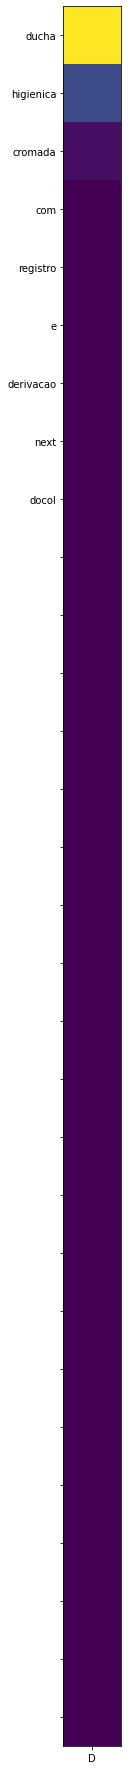

In [48]:
plot_attention_weights2(input_texts[seq_index], attention_weights, classe)

In [49]:
for seq_index in range(300):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    classe, attention_weights = classifier_substantive_sequence_txt(input_texts[seq_index])
    print(f'-{seq_index}')
    print('Input sentence:', input_texts[seq_index])
    print('Target:', target_substantive[seq_index])
    print('Predict:', classe)

-0
Input sentence: suporte lt minilock com rosca bralimpia para fibras de limpeza
Target: Suporte para Fibra de Limpeza
Predict: Suporte para Fibra de Limpeza
-1
Input sentence: ducha higienica cromada com registro e derivacao next docol
Target: Ducha Higiênica
Predict: Ducha Higiênica
-2
Input sentence: trava para tampa de fogao ou micro ondas branca fixtil
Target: Trava para Eletrodomésticos
Predict: Trava para Eletrodomésticos
-3
Input sentence: kit vinho e panela eletrica de fondue oster romance kit vinho e panela eletrica de fondue oster romance 220 v
Target: Aparelho de Fondue
Predict: Aparelho de Fondue
-4
Input sentence: passa verduras scala easy acea 20 cm 3 discos aco inox e pp branco ghidini
Target: Passa Verdura
Predict: Passa Verdura
-5
Input sentence: barril de balsamo premium 10 l 10000 ml barril barris
Target: Barril
Predict: Barril
-6
Input sentence: conjunto com 5 facas e cepo mundial
Target: Cepo
Predict: Cepo
-7
Input sentence: pote marmita com 3 compartimentos 1400

-66
Input sentence: mata barata kromax gel 10 g bisnaga
Target: Isca Mata Barata
Predict: Isca Mata Barata
-67
Input sentence: vassoura de nylon condor madri com cabo com 12
Target: Vassoura
Predict: Vassoura
-68
Input sentence: palitos de bambu torneados com 200 unid vendasshop utensilios limpeza
Target: Palito de Dente
Predict: Palito de Dente
-69
Input sentence: afiador de facas eletrico cinza escuro stang 127 v
Target: Afiador Elétrico
Predict: Afiador Elétrico
-70
Input sentence: fatiador picador 2 discos manual folhas hortalicas couve batata cenoura legumes vitalex fl2 i inox
Target: Fatiador de Alimentos
Predict: Fatiador de Alimentos
-71
Input sentence: caneta decoradora para confeitar fackelmann
Target: Caneta para Confeitaria
Predict: Caneta para Confeitaria
-72
Input sentence: lenha ecologica briquete lareira 35 kg 78786035 tramontina
Target: Lenha
Predict: Lenha
-73
Input sentence: lixeira para pia coza 10902 4 l natural
Target: Lixeira
Predict: Lixeira
-74
Input sentence: 

-134
Input sentence: jogo de tacas bodas de ouro brasfoot
Target: Jogo para Sushi
Predict: Jogo para Sushi
-135
Input sentence: suporte lixeira 25 l para cozinha c suporte saleiro ventosa future
Target: Suporte de Parede para Pia
Predict: Suporte de Parede para Pia
-136
Input sentence: suporte decorativo dourado soul home
Target: Suporte Decorativo
Predict: Suporte Decorativo
-137
Input sentence: acessorio mafaldine para atlas 150 marcato
Target: Acessórios para Máquina de Macarrão
Predict: Acessórios para Máquina de Macarrão
-138
Input sentence: estante organizadora com 6 compartimentos colorido cbr 1022 y6026
Target: Estante Organizadora
Predict: Estante Organizadora
-139
Input sentence: panquequeira brinox ceramic life 25 colour 4757 323 vermelha
Target: Panquequeira
Predict: Panquequeira
-140
Input sentence: velas alvorada no2
Target: Vela
Predict: Vela
-141
Input sentence: kit para biscoitos 9 pecas monsterchef 23799089 tramontina
Target: Kit para Biscoitos
Predict: Kit para Bisco

-199
Input sentence: capa para tabua de passar em algodao metalizado 124 cm x 45 cm brabantia c
Target: Capa Térmica para Tábua de Passar Roupa
Predict: Capa Térmica para Tábua de Passar Roupa
-200
Input sentence: porta hastes flexiveis de algodao atria vermelho brinox
Target: Porta Hastes Flexíveis de Algodão
Predict: Porta Hastes Flexíveis de Algodão
-201
Input sentence: pingometro bomba de combustivel 1 garrafa vermelho shell
Target: Pingômetro
Predict: Pingômetro
-202
Input sentence: ventilador acendedor soprador de churrasqueira eletrico lareira e carvao automatica a pilha paris
Target: Acendedor
Predict: Acendedor
-203
Input sentence: tampa para garrafa de vinho zr347 06 hauskraft
Target: Tampa para Garrafa
Predict: Tampa para Garrafa
-204
Input sentence: vassoura magica rodo magico shallper com 3 refis vendasshop utensilios de limpeza
Target: Rodo
Predict: Rodo
-205
Input sentence: conjunto toalheira de box suporte para shampoo papeleira de chao future
Target: Toalheiro
Predict:

-265
Input sentence: porta rocambole pequeno multiuso 15 cm 235r ricaelle
Target: Porta Rocambole
Predict: Porta Rocambole
-266
Input sentence: conjunto para bar com 3 pecas euro
Target: Conjunto para Bar
Predict: Conjunto para Bar
-267
Input sentence: jarra plastica para agua 38 litros san remo sanremo
Target: Jarra
Predict: Jarra
-268
Input sentence: forminha de papel mago no5 recortada c 100 unidades poas
Target: Forminha para Doces
Predict: Forminha para Doces
-269
Input sentence: kit cuba barcelona sobrepor banheiro com valvula click inox docelar
Target: Conjunto para Banheiro
Predict: Conjunto para Banheiro
-270
Input sentence: capa termica para mesa de passar roupa 100x43 cm 4021 mor
Target: Capa Térmica para Tábua de Passar Roupa
Predict: Capa Térmica para Tábua de Passar Roupa
-271
Input sentence: cepo com facas neoflam
Target: Cepo
Predict: Cepo
-272
Input sentence: bento box porta lanches e refeicoes urso 3 sprouts
Target: Porta Lanche
Predict: Porta Lanche
-273
Input senten

In [50]:
predict_train = []
context_vector_arrays_train = []
for seq_index in tqdm(range(len(input_texts)), total=len(input_texts)):
    classe, attention_weights = classifier_substantive_sequence_txt(input_texts[seq_index])
    context_vector, attention_weights = get_encoder_attention_context_vector(input_texts[seq_index])
    predict_train.append(classe)
    context_vector_arrays_train.append(context_vector)

 14%|█▍        | 5475/38960 [35:23<3:35:23,  2.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 44%|████▍     | 17209/38960 [1:50:48<2:37:04,  2.31it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 69%|██████▉   | 26794/38960 [2:53:06<1:14:12,  2.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--No

In [51]:
train_acc = accuracy_score(target_substantive, predict_train)
mlflow.log_metric('train_acc', train_acc)
train_acc

0.990682751540041

In [52]:
train_acc

0.990682751540041

Conjunto de Teste

In [53]:
input_texts_test = [dict_id_name[_id] for _id in data_test]
target_substantive_test = [dict_id_substantive[_id] for _id in data_test]

In [54]:
for seq_index in range(300):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    classe, attention_weights = classifier_substantive_sequence_txt(input_texts_test[seq_index])
    print(f'-{seq_index}')
    print('Input sentence:', input_texts_test[seq_index])
    print('Target:', int_to_label_dict[target_substantive_test[seq_index]])
    print('Predict:', classe)

-0
Input sentence: bomba para chimarrao inox pedra amarela mix atacadista
Target: Bomba para Chimarrão
Predict: Bomba para Chimarrão
-1
Input sentence: touca de tnt sanfonada branca com 100 unidades bioservice
Target: Touca Culinária
Predict: Touca Culinária
-2
Input sentence: jarra garrafa 14 l de cristal layers lyor l3527
Target: Jarra
Predict: Jarra
-3
Input sentence: conjunto de leiteira e acucareiro due wow aco inox
Target: Conjunto de Leiteira e Açucareiro
Predict: Conjunto de Leiteira e Açucareiro
-4
Input sentence: potiche decorativo lyor cactos ceramica 16 cm
Target: Potiche
Predict: Potiche
-5
Input sentence: relogio de mesa dourado solon 20x25 cm concepts life
Target: Relógio de Mesa
Predict: Relógio de Mesa
-6
Input sentence: porta treco jornal
Target: Porta Treco
Predict: Porta Treco
-7
Input sentence: suporte multiuso 20 cm espelhado redondo fume lyor l1046
Target: Suporte Multiuso
Predict: Suporte Multiuso
-8
Input sentence: forma de plastico para gelatina divertida kit 

-64
Input sentence: conjunto de tacas para licor diva schott 80 ml 6 unidades 19283
Target: Taça
Predict: Taça
-65
Input sentence: palito de dente em sache billa com 2000
Target: Palito de Dente
Predict: Palito de Dente
-66
Input sentence: triturador de cereais manual tritura milho soja trigo botini
Target: Triturador Manual
Predict: Triturador Manual
-67
Input sentence: conjunto 9 cortadores de massa linzer numeros 794201
Target: Cortador de Massa
Predict: Cortador de Massa
-68
Input sentence: kit forma para pastel medio  forma de ravioli mini pastel injetemp
Target: Kit para Massas
Predict: Kit para Massas
-69
Input sentence: batedor de carne agile tramontina
Target: Batedor de Carne
Predict: Batedor de Carne
-70
Input sentence: fonte de agua decorativa waterdrop com iluminacao bivolt relaxmedic rm fd8218 relax medic
Target: Fonte de Água
Predict: Fonte de Água
-71
Input sentence: vela moso bamboo colecao japonica 3 pavios lata 60 horas voluspa
Target: Vela
Predict: Vela
-72
Input se

-131
Input sentence: espeto giratorio eletrico pop girofest
Target: Espeto Giratório
Predict: Espeto Giratório
-132
Input sentence: decanter com suporte bakar revestimento cobre forma
Target: Decanter
Predict: Decanter
-133
Input sentence: conjunto organizador de pia e toalheiro de parede madeiramadeira cromado preto brinox
Target: Toalheiro
Predict: Toalheiro
-134
Input sentence: forminha para doces caminhonete e fusca garage route 66 24 unidades cromus
Target: Forminha para Doces
Predict: Forminha para Doces
-135
Input sentence: lenha de defumacao macieira bold
Target: Lenha
Predict: Lenha
-136
Input sentence: candelabro de poliresina corda 11 5 f9 25393 prestige
Target: Candelabro
Predict: Candelabro
-137
Input sentence: palitos para petiscos com copo de aco inox bone rojemac prata
Target: Palito para Petisco
Predict: Palito para Petisco
-138
Input sentence: rodo de aluminio para pia anfora
Target: Rodo de Pia
Predict: Rodo de Pia
-139
Input sentence: abridor garrafa canivete aco in

-198
Input sentence: caldeirao de barro com suporte no 3 sisiarte
Target: Caldeirão
Predict: Caldeirão
-199
Input sentence: forma cookie hearts silikomart silicone marrom
Target: Forma
Predict: Forma
-200
Input sentence: paliteiro vidro com tampa aco inox 50 ml parma brinox brx 319
Target: Paliteiro
Predict: Paliteiro
-201
Input sentence: tampa de silicone 30 cm laranja apollo
Target: Tampa de Silicone
Predict: Tampa de Silicone
-202
Input sentence: grill e bistequeira roichen antiaderente aluminio ceramica rosa 28 cm
Target: Bistequeira
Predict: Chapa para Churrasco
-203
Input sentence: forma de gelo smart ice brastemp original
Target: Forma de Gelo
Predict: Forma de Gelo
-204
Input sentence: ovo facil roxo dtc
Target: Forma para Fritar Ovo
Predict: Forma para Fritar Ovo
-205
Input sentence: cabo removivel smart square polishop
Target: Cabo para Panela
Predict: Cabo para Panela
-206
Input sentence: assento para cadeira futon 40x40 cm cinza couro cor cia
Target: Assento para Cadeira
Pr

-266
Input sentence: fogao a lenha no 2 seculo xv ludwig vitreo com tampa saida direita verde caldeira venax
Target: Caldeira
Predict: Caldeira
-267
Input sentence: porta rolos maxroll 3 suportes papel toalha pvc e aluminio purimax
Target: Porta Rolos
Predict: Porta Rolos
-268
Input sentence: porta geleia de prata italy 24cmx10 cm rojemac
Target: Porta Geleia
Predict: Porta Geleia
-269
Input sentence: assento para cadeira futton ox 40x40 cm oliva ecaza
Target: Assento para Cadeira
Predict: Assento para Cadeira
-270
Input sentence: pacote de touca tnt c 100 unidades talge
Target: Touca Culinária
Predict: Touca Culinária
-271
Input sentence: suporte para condimentos e 2 rolos arthi
Target: Porta Papel Toalha
Predict: Porta Papel Toalha
-272
Input sentence: porta detergente e bucha para pendurar cook home arthi 1437
Target: Porta Sabão e Detergentes
Predict: Porta Sabão e Detergentes
-273
Input sentence: rack extensor para steakhouse grill polishop
Target: Extensor para Grill
Predict: Ext

In [55]:
predict_test = []
context_vector_arrays_test = []

for seq_index in tqdm(range(len(input_texts_test))):
    classe, attention_weights = classifier_substantive_sequence_txt(input_texts_test[seq_index])
    context_vector, attention_weights = get_encoder_attention_context_vector(input_texts_test[seq_index])
    predict_test.append(classe)
    context_vector_arrays_test.append(context_vector)

 31%|███       | 2999/9740 [19:11<47:16,  2.38it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 9740/9740 [1:02:59<00:00,  2.58it/s]


In [56]:
predict_test

['Bomba para Chimarrão',
 'Touca Culinária',
 'Jarra',
 'Conjunto de Leiteira e Açucareiro',
 'Potiche',
 'Relógio de Mesa',
 'Porta Treco',
 'Suporte Multiuso',
 'Forma de Plástico',
 'Descanso para Talheres',
 'Conjunto para Massa',
 'Bomba para Chimarrão',
 'Mexedor de Bebidas',
 'Forma de Plástico',
 'Dispenser de Sabonete',
 'Saco para Lavar Roupas',
 'Bomba Vácuo',
 'Porta Lenços de Papel',
 'Porta Frios',
 'Descanso para Talheres',
 'Dispenser de Alimento',
 'Conjunto de Bowls',
 'Guardanapo',
 'Copo Medidor',
 'Vassoura',
 'Tábua de Passar',
 'Bandeja para Sofá',
 'Arejador para Torneira',
 'Molde para Massas',
 'Anel para Espeto',
 'Conjunto para Massa',
 'Bailarina Giratória',
 'Porta Utensílios',
 'Infusor para Chá',
 'Barca para Sushi',
 'Porta Rolos',
 'Tigela',
 'Palito para Sorvete',
 'Porta Sabão',
 'Pedra para Assar Pizza',
 'Bistequeira',
 'Dispenser para Bebidas',
 'Armadilha para Animais',
 'Espelho Decorativo',
 'Suporte Decorativo',
 'Assadeira',
 'Rodo de Pia',
 

In [60]:
len(context_vector_arrays_test)

9740

In [57]:
target_test_acc_score = [int_to_label_dict[target] for target in target_substantive_test]

In [58]:
test_acc = accuracy_score(target_test_acc_score, predict_test)
mlflow.log_metric('test_acc', test_acc)
test_acc

0.9596509240246407

In [59]:
test_acc

0.9596509240246407

In [72]:
context_vector_arrays_train_2_df = [vector[0] for vector in context_vector_arrays_train]

In [61]:
df_train_intermediate_layer = pd.DataFrame()

Pré-Processamento dos camposde

In [62]:
df_train_intermediate_layer['_id'] = data_train_val

In [64]:
df_train_intermediate_layer['input_model'] = input_texts

In [73]:
df_train_intermediate_layer['intermed_layer'] = context_vector_arrays_train_2_df

In [66]:
df_train_intermediate_layer['predict'] = predict_train

In [67]:
df_train_intermediate_layer['target'] = target_substantive

In [74]:
df_train_intermediate_layer.head(10)

,_id,input_model,intermed_layer,predict,target
0,5b33c4a67c713d82c21fdccf,suporte lt minilock com rosca bralimpia para f...,"[0.1358057, -0.033409834, 0.022917738, 0.01485...",Suporte para Fibra de Limpeza,Suporte para Fibra de Limpeza
1,5be0e3d07c713d19790bdaa5,ducha higienica cromada com registro e derivac...,"[0.06779552, 0.120232716, 0.18659014, -0.05309...",Ducha Higiênica,Ducha Higiênica
2,5cde319c3ccf2dc3b85aca71,trava para tampa de fogao ou micro ondas branc...,"[0.029977474, 0.07517773, 0.17371787, 0.099232...",Trava para Eletrodomésticos,Trava para Eletrodomésticos
3,5b168694a3f6b8c98c467ef9,kit vinho e panela eletrica de fondue oster ro...,"[0.22540824, -0.33602434, -0.057162132, 0.4493...",Aparelho de Fondue,Aparelho de Fondue
4,5d38ee9d8a602a15e4d5edbd,passa verduras scala easy acea 20 cm 3 discos ...,"[0.04632015, 0.054507487, 0.30652964, 0.040773...",Passa Verdura,Passa Verdura
5,5be693687c713d19790d81fc,barril de balsamo premium 10 l 10000 ml barril...,"[0.13190047, -0.07719616, 0.10922781, 0.149922...",Barril,Barril
6,5b2043a47c713d38a2c87045,conjunto com 5 facas e cepo mundial,"[0.014818218, -0.23933783, 0.002597696, 0.3760...",Cepo,Cepo
7,5cafa6583ccf2dc3b8c1c6fd,pote marmita com 3 compartimentos 1400 ml rosa...,"[0.06420259, 0.2329358, 0.24186021, -0.0740305...",Marmita,Marmita
8,5b20373e7c713d38a2c69243,cuia para chimarrao terere artesanal de porong...,"[0.10415619, 0.20160632, 0.1371904, -0.0368369...",Cuia para Chimarrão,Cuia para Chimarrão
9,5ca7b7953ccf2dc3b8b9e347,kit 3 pecas cuba vidro azul 41 cm torneira li...,"[0.14157785, -0.43902627, -0.004549923, 0.7062...",Conjunto para Banheiro,Conjunto para Banheiro


In [75]:
df_train_intermediate_layer.to_csv('entity_model_train_input_intermediate_layer_predict.csv', index=False)

In [70]:
import ast
import numpy as np
def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [76]:
df2 = pd.read_csv('entity_model_train_input_intermediate_layer_predict.csv', converters={'intermed_layer': from_np_array})
df2.head(10)

ValueError: malformed node or string: <_ast.Ellipsis object at 0x7ff2a4c404a8>

In [78]:
df_train_intermediate_layer.to_pickle('entity_model_train_input_intermediate_layer_predict.csv')

In [79]:
df = pd.read_pickle('entity_model_train_input_intermediate_layer_predict.csv')

In [82]:
type(df.iloc[0].intermed_layer)

numpy.ndarray

In [83]:
context_vector_arrays_test_2_df = [vector[0] for vector in context_vector_arrays_test]

In [85]:
df_test_intermediate_layer = pd.DataFrame()
df_test_intermediate_layer['_id'] = data_test
df_test_intermediate_layer['input_model'] = input_texts_test
df_test_intermediate_layer['intermed_layer'] = context_vector_arrays_test_2_df
df_test_intermediate_layer['predict'] = predict_test
df_test_intermediate_layer['target'] = target_test_acc_score
df_test_intermediate_layer.head(10)

,_id,input_model,intermed_layer,predict,target
0,5cede05e3ccf2dc3b8902b05,bomba para chimarrao inox pedra amarela mix at...,"[0.022280768, 0.12410732, 0.07139008, 0.037683...",Bomba para Chimarrão,Bomba para Chimarrão
1,5b441cb77c713d9bdf238cb4,touca de tnt sanfonada branca com 100 unidades...,"[0.047396496, 0.15161681, 0.07402253, -0.08862...",Touca Culinária,Touca Culinária
2,5b2298a27c713d38a2d73965,jarra garrafa 14 l de cristal layers lyor l3527,"[0.114793986, 0.21681733, 0.21089509, 0.021065...",Jarra,Jarra
3,5b283da87c713d38a20df9e5,conjunto de leiteira e acucareiro due wow aco ...,"[0.06784505, -0.5109016, -0.0055393837, 0.0660...",Conjunto de Leiteira e Açucareiro,Conjunto de Leiteira e Açucareiro
4,5caa24663ccf2dc3b8bda0c3,potiche decorativo lyor cactos ceramica 16 cm,"[0.2570054, -0.08244958, 0.329898, 0.17220014,...",Potiche,Potiche
5,5b3e3f587c713d9bdf118531,relogio de mesa dourado solon 20x25 cm concept...,"[-0.0022119111, -0.03619928, -0.023314707, -0....",Relógio de Mesa,Relógio de Mesa
6,5b27ef437c713d38a20d4776,porta treco jornal,"[0.0777386, 0.22187476, 0.26882938, -0.0327207...",Porta Treco,Porta Treco
7,5b2045db7c713d38a2c8cbfb,suporte multiuso 20 cm espelhado redondo fume ...,"[0.097266525, -0.011455443, 0.004186545, -0.07...",Suporte Multiuso,Suporte Multiuso
8,5c360fe97c713d1556a5d4f3,forma de plastico para gelatina divertida kit ...,"[0.055292204, 0.21938217, 0.12261605, -0.00552...",Forma de Plástico,Forma de Plástico
9,5b20073e7c713d38a2c339f5,descanso para talher de ceramica le creuset ve...,"[0.16309029, -0.082757585, 0.1540461, -0.00380...",Descanso para Talheres,Descanso para Talheres


In [86]:
df_test_intermediate_layer.to_pickle('entity_model_test_input_intermediate_layer_predict.csv')

In [87]:
df2 = pd.read_pickle('entity_model_test_input_intermediate_layer_predict.csv')

### Teste de novas entidades 

In [13]:
int_to_label_dict_file = "models/int_to_label_brand.json"

In [14]:
with open(int_to_label_dict_file) as json_file:
    int_to_label_dict = json.load(json_file)
    
label_to_int_dict = dict(
    (label, i) for i, label in int_to_label_dict.items())

In [15]:
filepath = 's2cls_substantive_extract_char_w2v_attention_01.h5'

with CustomObjectScope({'Attention_Bahdanau': Attention_Bahdanau}):
    model = load_model(filepath)
    
model.summary()

/opt/anaconda3/envs/entity-extractor2/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:542: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  append_fn(tensor_proto, proto_values)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 256)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 30, 100)      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 30, 600), (N 1336800     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 30, 600), (N 962400      input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [16]:
#load input char embedding

model_char = load_model(char_embedding_model_file, compile=False)

encoder_inputs = model_char.input[0] #input_1
encoder_outputs, state_h_enc, state_c_enc = model_char.layers[2].output # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = ModelKeras(encoder_inputs, encoder_states)
wordchar2vec = encoder_model

with open(char_to_int_dict_file) as json_file:
    char_to_int_dict = json.load(json_file)

#load input word2vec embedding
word2vec = Word2Vec.load(input_w2v_file)

In [17]:
params = {
          'dim_char': (30, 256),
          'dim_w2v': (30, 100),
          'batch_size': 200,
          'n_classes': len(label_to_int_dict.keys()),
          'shuffle': True, 
          'wordchar2vec': wordchar2vec,
          'word2vec': word2vec,
          'max_char_lenght': max_char_lenght,
          'max_length': max_length,
          'char_to_int_dict': char_to_int_dict
         }

In [18]:
encoder_char_inputs = model.input[0] #input_1
encoder_char = model.layers[2]
encoder_char_outputs, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_char(encoder_char_inputs)

encoder_char_model = ModelKeras(inputs = [encoder_char_inputs], outputs =[encoder_char_outputs, forward_h1, forward_c1, backward_h1, backward_c1])

encoder_w2v_inputs = model.input[1] #input_2
encoder_w2v = model.layers[3]
encoder_w2v_outputs, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_w2v(encoder_w2v_inputs)

encoder_w2v_model = ModelKeras(inputs = [encoder_w2v_inputs], outputs =[encoder_w2v_outputs, forward_h2, forward_c2, backward_h2, backward_c2])

encoder_inf_outputs = Input(shape=(max_length, 4*n_hidden_nodes,), name='encoder_inf_output')
encoder_inf_state_h = Input(shape=(4*n_hidden_nodes,), name='encoder_inf_states')
attn_layer = model.layers[8]
context_vector, attention_weights = attn_layer([encoder_inf_outputs, encoder_inf_state_h])

decoder_dense = model.layers[9]
decoder_inf_pred=decoder_dense(context_vector)

classifier_model = ModelKeras(inputs=[encoder_inf_outputs, encoder_inf_state_h],
                           outputs=[decoder_inf_pred, attention_weights])


In [19]:
classifier_model_itermed_layer = ModelKeras(inputs=[encoder_inf_outputs, encoder_inf_state_h],
                           outputs=[context_vector, attention_weights])


In [20]:
df_new_offers = pd.read_csv('offers_new_entitys_utilidades_domestica_03062020.csv')

In [21]:
df_new_offers.shape

(394, 8)

In [22]:
df_new_offers.columns

Index(['_id', 'store', 'name', 'structured_metadata', 'substantive', 'entity',
       'niche', 'created_at'],
      dtype='object')

In [27]:
list(label_to_int_dict.keys())

['Abafador de Vela',
 'Abafador para Alimentos',
 'Abajur',
 'Abridor',
 'Abridor de Cartas',
 'Acendedor',
 'Acessórios para Máquina de Macarrão',
 'Afiador',
 'Afiador Elétrico',
 'Amaciador de Carne Manual',
 'Amassador de Alimentos',
 'Amassador de Lata',
 'Amolador de Facas',
 'Ampulheta',
 'Amônia',
 'Anel Expansível para Fatiar Bolos',
 'Anel para Espeto',
 'Aparador de Livros',
 'Aparelho de Fondue',
 'Aparelho de jantar',
 'Aplicador de Fita Adesiva',
 'Apoio para Hashi',
 'Arara para Roupas',
 'Arejador para Torneira',
 'Armadilha para Animais',
 'Armadilha para Insetos',
 'Aro para Lixeira',
 'Assadeira',
 'Assento para Cadeira',
 'Azeiteiro/Vinagreiro',
 'Açucareiro',
 'Bacia',
 'Bailarina Giratória',
 'Baixela',
 'Balança',
 'Balde',
 'Balde de Gelo',
 'Balde de Pipoca',
 'Balde para Bebida',
 'Baleiro',
 'Bandeja',
 'Bandeja Perfurada para Cuba',
 'Bandeja para Banheiro',
 'Bandeja para Sofá',
 'Bandeja para Sushi',
 'Barca para Sushi',
 'Barra Multiuso',
 'Barril',
 'Bas

In [29]:
list_new_entitys = list(set(df_new_offers.substantive.values.tolist()))
list_new_entitys

['Base para Varal de Parede',
 'Capa para Faca',
 'Adaptador para Bico de Confeitar',
 'Degrau para Banheiro',
 'Extensor de Suporte para TV',
 'Tábua de Lavar',
 'Porta Filtro de Café',
 'Lenço Furoshiki',
 'Aplicador de Pérolas para Confeitaria',
 'Adaga',
 'Anel de Vedação para Garrafa de Chantilly',
 'Porta Máscara Cirúrgica',
 'Cesta de Supermercado',
 'Turibulo',
 'Aspersório',
 'Alça para Carregar Sacolas',
 'Abridor para Galão de Água',
 'Abafador para Narguilé',
 'Conjunto Esotérico',
 'Limpador Magnético',
 'Limpador de Lente',
 'Forma para Torre de Batata',
 'Suporte para Galão de Água',
 'Redutor para Cachimbo',
 'Alça para Garrafa',
 'Alça para Galão de Água',
 'Espátula Alisadora para Confeitaria',
 'Porta Canudo',
 'Pêndulo',
 'Base para Tocha',
 'Lamparina',
 'Pedra Esotérica',
 'Armador de Flor para Confeitaria',
 'Defumador de Ambiente']

In [31]:
len(list_new_entitys)

34

In [34]:
len(list(label_to_int_dict.keys()))

487

In [37]:
int_to_label_dict[str(325)]

'Polvilhador'

In [30]:
for value in list_new_entitys:
    if value not in list(label_to_int_dict.keys()):
        print(value)

Base para Varal de Parede
Capa para Faca
Adaptador para Bico de Confeitar
Degrau para Banheiro
Extensor de Suporte para TV
Tábua de Lavar
Porta Filtro de Café
Lenço Furoshiki
Aplicador de Pérolas para Confeitaria
Adaga
Anel de Vedação para Garrafa de Chantilly
Porta Máscara Cirúrgica
Cesta de Supermercado
Turibulo
Aspersório
Alça para Carregar Sacolas
Abridor para Galão de Água
Abafador para Narguilé
Conjunto Esotérico
Limpador Magnético
Limpador de Lente
Forma para Torre de Batata
Suporte para Galão de Água
Redutor para Cachimbo
Alça para Garrafa
Alça para Galão de Água
Espátula Alisadora para Confeitaria
Porta Canudo
Pêndulo
Base para Tocha
Lamparina
Pedra Esotérica
Armador de Flor para Confeitaria
Defumador de Ambiente


In [24]:
#Pre processing txt
df_new_offers[input_column] = df_new_offers[input_column].swifter.apply(text_preprocessing)

In [25]:
df_new_offers[input_column]

0                 lev facil carregador de sacolas ordene
1      suporte para galao de agua mineral 10 20 lts p...
2      suporte para galao de agua mineral branco unit...
3      kit 2un suporte para galao de agua mineral 10 ...
4                        pendulo de newton balance balls
5      suporte para galao de agua com torneira tifany...
6      pendulo cinetico giratorio magnetico movimento...
7      suporte para galao de agua de ate 20 litros ti...
8               suporte quadrado para galao de agua camp
9      kit 2un suporte para galao de agua mineral 10 ...
10     kit pendulo newton luxo preto metal madeira  a...
11     suporte para galao de agua com torneira tifany...
12     kit 2un suporte para galao de agua mineral 10 ...
13     kit 2un suporte para galao de agua mineral 10 ...
14     pendulo cinetico mobile giratorio colorido pil...
15     suporte para galao garrafao de agua com tornei...
16     suporte p galao de agua 10 l 20 l inox c cuba ...
17     pendulo cinetico mobile 

In [32]:
input_texts = df_new_offers.name.values.tolist()

In [39]:
predict = []
context_vector_arrays = []

for seq_index in tqdm(range(len(input_texts))):
    classe, attention_weights = classifier_substantive_sequence_txt(input_texts[seq_index])
    context_vector, attention_weights = get_encoder_attention_context_vector(input_texts[seq_index])
    predict.append(classe)
    context_vector_arrays.append(context_vector)

100%|██████████| 394/394 [04:40<00:00,  1.40it/s]


In [40]:
context_vector_arrays

[array([[ 0.89726907, -0.34264675, -0.8393518 , ..., -0.07361396,
          0.13261707, -0.08564696]], dtype=float32),
 array([[ 0.86681455, -0.49346077, -0.7618877 , ..., -0.14800557,
         -0.10596996, -0.20897202]], dtype=float32),
 array([[ 0.8154355 , -0.41831964, -0.6955809 , ..., -0.11451817,
          0.01951065, -0.19768964]], dtype=float32),
 array([[ 0.87843496, -0.32256576, -0.8074065 , ..., -0.2475649 ,
         -0.21291418, -0.30946505]], dtype=float32),
 array([[ 0.93932307, -0.645825  , -0.8111839 , ..., -0.03886474,
          0.00557656, -0.05275792]], dtype=float32),
 array([[ 0.8939806 , -0.49497047, -0.8235246 , ..., -0.12222771,
         -0.08971498, -0.11621824]], dtype=float32),
 array([[ 0.96439946, -0.32184672, -0.93876195, ..., -0.06022281,
         -0.01626232, -0.02211528]], dtype=float32),
 array([[ 0.8662299 , -0.48722756, -0.7684679 , ..., -0.02573216,
         -0.12439363, -0.14888977]], dtype=float32),
 array([[ 0.90999585, -0.47583735, -0.6672283 , 

In [41]:
predict

['Polvilhador',
 'Mop',
 'Mop',
 'Mop',
 'Manta para Grelha',
 'Mop',
 'Manta para Grelha',
 'Mop',
 'Mop',
 'Mop',
 'Mop',
 'Mop',
 'Mop',
 'Mop',
 'Manta para Grelha',
 'Mop',
 'Mop',
 'Manta para Grelha',
 'Mop',
 'Mop',
 'Mop',
 'Manta para Grelha',
 'Manta para Grelha',
 'Polvilhador',
 'Mop',
 'Polvilhador',
 'Moringa',
 'Polvilhador',
 'Manta para Grelha',
 'Mop',
 'Manta para Grelha',
 'Polvilhador',
 'Polvilhador',
 'Mop',
 'Mop',
 'Boleador',
 'Mop',
 'Boleador',
 'Estante Organizadora',
 'Manta para Grelha',
 'Mop',
 'Mop',
 'Mop',
 'Polvilhador',
 'Mop',
 'Mop',
 'Mop',
 'Manta para Grelha',
 'Manta para Grelha',
 'Mop',
 'Mop',
 'Manta para Grelha',
 'Polvilhador',
 'Manta para Grelha',
 'Mop',
 'Manta para Grelha',
 'Manta para Grelha',
 'Mop',
 'Mop',
 'Polvilhador',
 'Manta para Grelha',
 'Mop',
 'Mop',
 'Hamburgueira',
 'Estante Organizadora',
 'Polvilhador',
 'Polvilhador',
 'Estante Organizadora',
 'Estante Organizadora',
 'Polvilhador',
 'Polvilhador',
 'Polvilhador

In [42]:
df_new_offers_intermediate_layer = pd.DataFrame()

Pré-Processamento dos camposde

In [43]:
df_new_offers_intermediate_layer['_id'] = df_new_offers._id.values.tolist()

In [44]:
df_new_offers_intermediate_layer['input_model'] = df_new_offers.name.values.tolist()

In [45]:
df_new_offers_intermediate_layer['intermed_layer'] = context_vector_arrays

In [46]:
df_new_offers_intermediate_layer['predict'] = predict

In [48]:
df_new_offers_intermediate_layer['target'] = df_new_offers.substantive.values.tolist()

In [49]:
df_new_offers_intermediate_layer.head(10)

,_id,input_model,intermed_layer,predict,target
0,5eb0466f4935cb0001dd6895,lev facil carregador de sacolas ordene,"[[0.89726907, -0.34264675, -0.8393518, 0.89035...",Polvilhador,Alça para Carregar Sacolas
1,5e58307e2679030001d3f8e0,suporte para galao de agua mineral 10 20 lts p...,"[[0.86681455, -0.49346077, -0.7618877, 0.80995...",Mop,Suporte para Galão de Água
2,5dcc110b8a602a90302d9efe,suporte para galao de agua mineral branco unit...,"[[0.8154355, -0.41831964, -0.6955809, 0.755636...",Mop,Suporte para Galão de Água
3,5e18242a71b8900001e39ba3,kit 2un suporte para galao de agua mineral 10 ...,"[[0.87843496, -0.32256576, -0.8074065, 0.87192...",Mop,Suporte para Galão de Água
4,5c88052a3ccf2dc3b8ebea79,pendulo de newton balance balls,"[[0.93932307, -0.645825, -0.8111839, 0.8342354...",Manta para Grelha,Pêndulo
5,5ea060854935cb0001cb08ec,suporte para galao de agua com torneira tifany...,"[[0.8939806, -0.49497047, -0.8235246, 0.859267...",Mop,Suporte para Galão de Água
6,5ed719a83d7a8700010d54b1,pendulo cinetico giratorio magnetico movimento...,"[[0.96439946, -0.32184672, -0.93876195, -0.972...",Manta para Grelha,Pêndulo
7,5d864c458a602a9d42a845fe,suporte para galao de agua de ate 20 litros ti...,"[[0.8662299, -0.48722756, -0.7684679, 0.864248...",Mop,Suporte para Galão de Água
8,5b2037017c713d38a2c689bf,suporte quadrado para galao de agua camp,"[[0.90999585, -0.47583735, -0.6672283, 0.40173...",Mop,Suporte para Galão de Água
9,5e18248471b8900001e39d1d,kit 2un suporte para galao de agua mineral 10 ...,"[[0.87843496, -0.32256576, -0.8074065, 0.87192...",Mop,Suporte para Galão de Água


In [52]:
df_new_offers_intermediate_layer.to_pickle('entity_model_new_entity_offer_input_intermediate_layer_predict.csv')

In [53]:
df0 = pd.read_pickle('entity_model_new_entity_offer_input_intermediate_layer_predict.csv')

In [57]:
df0.iloc[0].intermed_layer[0].shape

(1200,)

In [50]:
import ast
import numpy as np
def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [76]:
df2 = pd.read_csv('entity_model_new_entity_offer_input_intermediate_layer_predict.csv', converters={'intermed_layer': from_np_array})
df2.head(10)

ValueError: malformed node or string: <_ast.Ellipsis object at 0x7ff2a4c404a8>